# Projet 7

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A cette étape, nous avons deux fichiers :

1- un fichier de données d'entrainement qui nous permettra de faire du ML supervisé afin de modéliser des profils clients et de leur attribuer une probabilité de solvabilité qui aboutira à une classication 0/1.

2- un fichier de données de test avec des nouveaux clients qui servira pour l'inférence de ce modèle entrainé

In [2]:
import pandas as pd
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split

## Partie 3 : Créez un score métier pour l'entrainement de vos modèles

L'objectif de cette partie sera de définir le score de performance du modèle ML pour traiter la problèmatique

### 1- L'exactitude ou accuracy

Dans un modèle de classification le premier score de performance utilisé est l'accuracy qui donne un pourcentage des classifications correctement réalisées.

Dans notre cas, ce score n'est pas optimal car nous avons vu précédemment qu'il y a avait un énorme déséquilibre de classe entre les bons et les mauvais clients : on a une sur-représentation de la classe target == 0

Enfin, on souhaite attribuer un coût plus élevé pour des Faux Positifs (= on accorde un crédit à un mauvais client et donc le défaut de paiement coûte cher) que pour les Faux Négatifs (= on n'accorde pas de crédit à un client solvable)

On pourra seulement l'utiliser comme baseline

### 2- Rappel et Précision

Dans un ensemble de données déséquilibré où le nombre de positifs réels est très faible, le rappel est une métrique plus pertinente que la précision, car il mesure la capacité du modèle à identifier correctement toutes les instances positives.

Un faux négatif a des conséquences plus graves qu'un faux positif.

Dans notre cas, nous voulons surtout détecter les mauvais payeurs donc minimiser les FN = les mauvais payeurs prédits 0 alors qu'ils sont en réalité 1, il nous faudra donc maximiser le rappel.

Il faudra établir une matrice de confusion qui résumera TP TN FP FN afin de comprendre comment un modèle se trompe

### 3- ROC et AUC_ROC

La courbe ROC : Rappel = f(taux de FP); montre la performance du modèle à classifier selon les seuils de probabilité

AUC_ROC : aire sous la courbe ROC; montre la capacité du modèle à bien distinguer les classes
AUC = 0.5 (le modèle classe les clients au hasard) AUC = 1.0 (le classifieur ne fait aucune erreur)

On utilisera AUC pour comparer les différents classifieurs

### 4- F-Beta_score

Le F1_score donne la moyenne harmonique entre précision et rappel : on veut un modèle qui équilibre la précision et le rappel.

Le F-beta_score est une métrique qui combine la précision et le rappel en une seule valeur mais en donnant plus ou moins d'importance à l'une des deux selon le paramètre beta.


On utilisera le Fbeta_score = 2 pour favoriser le rappel plutôt que la précision

## Partie 4 : Simulez et comparez plusieurs modèles

L'objectif ici sera d'évaluer plusieurs modèles de classifieurs sur nos données d'entrainement et de comparer leurs performances via l'outil de mlflow tracking

### 4-1 loading des data

In [3]:
X = pd.read_csv('/content/drive/MyDrive/DATA/DATA_cleaned/application_train_final.csv')

In [4]:
y = X['TARGET']
X = X.drop(columns=['TARGET'])

In [5]:
X.isna().sum().sum()  # Vérification des valeurs manquantes

np.int64(5669948)

In [6]:
X.dtypes.unique()

array([dtype('float64')], dtype=object)

In [7]:
print("Valeurs manquantes :", X.isnull().sum().sum())
print("Valeurs infinies :", np.isinf(X).sum().sum())

Valeurs manquantes : 5669948
Valeurs infinies : 1304


On a bien uniquement des valeurs numériques encodées mais des valeurs manquantes et des valeurs infinies qu'il faudra imputer pour que le modèle puisse apprendre.

Pour éviter la fuite de données on va spliter le dataset avant de faire de préprocesser le dataset.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4-2 Elaboration du pipeline d'entrainement du ML

L'objectif sera de définir un pipeline qui permettra pour chacun des différents modèles sélectionnés, de préparer les données et de lancer les entrainements avec pour chaque modèle testé, différentes combinaisons d'hyperparamètres et métriques de performance

Workflow du pipeline :

- préparation des data :
    - imputation des valeurs manquantes
    - standardisation des variables

- initialisation des modèles à tester et des grilles d'hyperparamètres associés

- intégration des techniques de ré-équilibrage des classes

- RandomSearchCV des hyperparamètres et run des entrainements des différents modèles

- intégration avec MLFlow et logge des métriques

#### 4-2-1 Preprocessing des data

On va commencer par remplacer les valeurs infinies par la valeur NaN pour qu'on puisse ensuite les imputer lors du preprocessing

In [9]:
# Remplacer les valeurs infinies par NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

Pour les variables binaires on imputera avec la valeur la plus fréquente et pour les autres avec la mediane et on fera une standardisation

In [10]:
missing_cols = X.columns[X.isnull().any()]

In [11]:
bin_col = [col for col in missing_cols if X[col].nunique() == 2]
num_col = [col for col in missing_cols if X[col].nunique() > 2]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [13]:
# pipeline d'imputation pour les variables binaires
bin_transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy='most_frequent'))])

# pipeline d'imputation et de standardisation pour les valeurs numériques
num_transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

On utilisera un ColumnTransformer pour gérer le préprocessing des données dans le pipeline.

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('bin', bin_transformer, bin_col)],
    remainder='passthrough'
    )

#### 4-2-2 Pipeline de la baseline

On va tester l'entrainement d'un premier classifier sur le jeu de données pour établie une baseline

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced')) # on gère le déséquilibre avec class_weight='balanced'
    ])

In [ ]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CREDITCARD_CREDIT_UTILIZATION_MEAN',
                                                   'CREDITCARD_CNT_DRAWINGS_ATM_CURRENT_MEAN',
                                                   'CREDITCARD_CNT_DRAWINGS_CURRENT_MAX',
                                                   'CREDITCARD_CREDIT_UTILIZATION_MAX',
                                                   'DAYS_CRE...
                                                   'DAYS_CREDIT_ENDDATE_mean',
                                                   'DAYS_DECISION_mean',
                                                   'FLOORSMAX_AVG',
                                                   'FLOORSMAX_MEDI',
                                                   'FLOORSMAX_MODE',
                                                   'RATE_DOWN_PAYMENT_max',
                                                   'AMT_GOODS_PRICE',
                                                   'OWN_CAR_AGE',
                                                   'DAYS_CREDIT_ENDDATE_max',
                                                   'HOUR_APPR_PROCESS_START_mean', ...]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Evaluons les perfomances de ce premier modèle

In [ ]:
# 1- Prédictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay, fbeta_score

In [ ]:
# 2- Évaluation des performances
# f0.5_score
f2 = fbeta_score(y_test, y_pred, beta=0.5)
print("F2-score :", f2)

F2-score : 0.16219535329532633


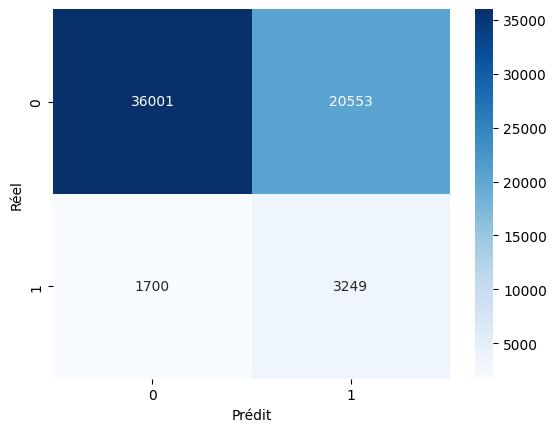

In [ ]:
# matrice de confusion
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

On a 20553 FP, ils ont été classés mauvais payeurs alors qu'ils étaient solvables
On a 1700 FN, ils sont été classés solvables alors qu'ils ne le sont pas.

AUC-ROC : 0.7041473201711388


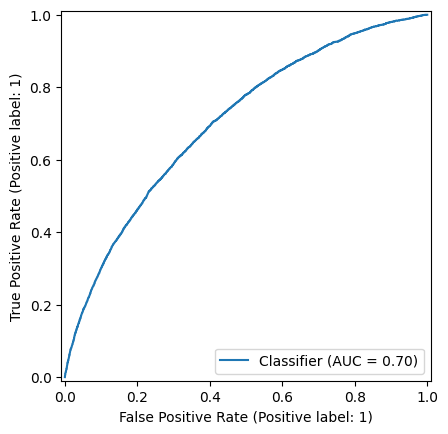

In [ ]:
# auc-roc
auc_roc = roc_auc_score(y_test, y_proba)
print("AUC-ROC :", auc_roc)
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

In [ ]:
feat_importances = clf.named_steps['model'].coef_[0] # calcul des importances des features
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feat_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
64,RATE_DOWN_PAYMENT_mean,0.136959
65,FLOORSMIN_MEDI,0.134157
56,HOUR_APPR_PROCESS_START_mean,0.120905
55,EMPLOYABILITY_STABILITY,0.112531
68,LIVINGAREA_MEDI,0.104724
72,AMT_ANNUITY_min,0.103810
78,APP_CREDIT_PERC_max,0.096178
15,DAYS_CREDIT_UPDATE_mean,0.095592
0,EXT_SOURCE_2,0.093234
66,WALLSMATERIAL_MODE_Panel,0.092860


<Axes: xlabel='Importance', ylabel='Feature'>

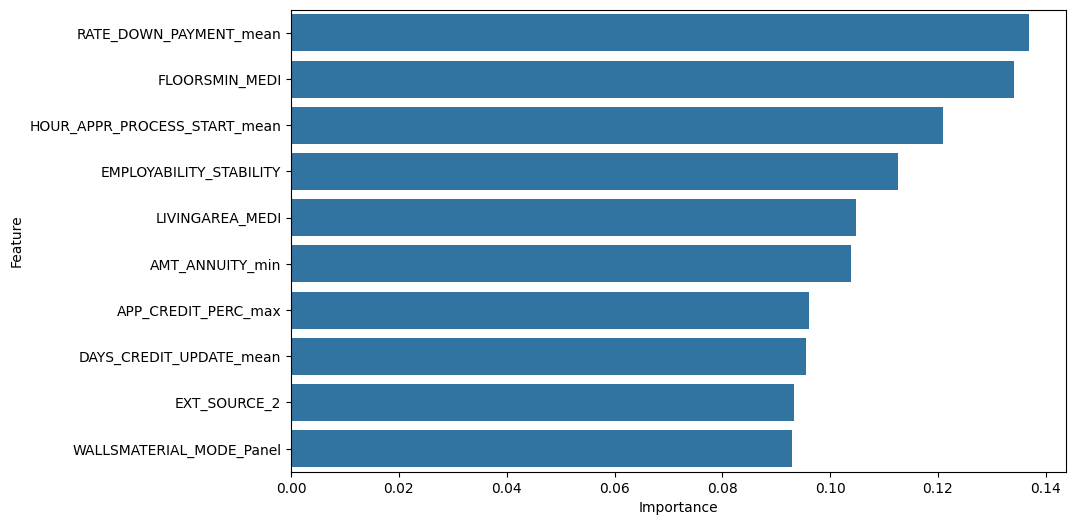

In [ ]:
# visualisation des 10 features les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))

#### 4-2-2 Définition de la grille des modèles / hyperparamètres

On va définir les différents modèles que l'on souhaite utiliser, les hyperparamètres à tester ainsi que les métriques que l'on souhaite suivre.

In [15]:
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [16]:
# définition du dictionnaire des modeles à tester et leurs hyperparamètres associés
model_params_grid = {
    "RandomForest": {
        'model' : RandomForestClassifier(class_weight='balanced'),
        "params": {
            "model__n_estimators": randint(100, 300),
            "model__max_depth": randint(3, 20),
            "model__min_samples_split": randint(2, 10),
            "model__min_samples_leaf": randint(1, 5)
        }
    },
    "XGBoost": {
        'model' : XGBClassifier(),
        "params": {
            "model__n_estimators": randint(100, 500),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__max_depth": randint(2, 6),
            "model__subsample": uniform(0.7, 0.3),        # valeurs entre 0.7 et 1.0
            "model__colsample_bytree": uniform(0.7, 0.3) # idem
        }
    },
    "LightGBM": {
        'model' : LGBMClassifier(class_weight='balanced'),
        "params":{
            "model__learning_rate": uniform(0.01, 0.1),
            "model__max_depth": [-1, 3, 5, 7, 9],
            "model__num_leaves": randint(20, 100),
            "model__n_estimators": randint(100, 500)
        }
    },
            }

In [17]:
# définition des métriques à suivre
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, roc_auc_score
scoring = {
    'accuracy': 'accuracy', # métrique baseline
    'fbeta': make_scorer(fbeta_score, beta = 2), # métrique principale
    "roc_auc": "roc_auc" # métrique pour comparer les modèles
}

#### 4-2-3 Rééquilibrage des classes

On va rééquilibrer les classes de notre dataset d'entrainement pour que les algorothmes puissent capturer la classe minoritaire

In [18]:
y.value_counts(normalize=True)

,proportion
TARGET,
0,0.919271
1,0.080729


On a un très fort déséquilibrage des classes. Pour palier à ce problème et éviter que les modèles n'apprennent que sur la classe majoritaire on peut recourir à des techniques de ré-échantillonnage :
- on enlève des individus de la classe majoritaire
- on ajoute des individus dans la classe minoritaire

La library Imblearn a plusieurs méthodes de ré-échantillonage:   
- RandomUnderSampler : sous-echantillonne au hasard la classe majoritaire avec ou sans remplacement
- RandomOverSampler : génère de nvx ech dans la classe minoritaire
- Tomek : crée des paires des deux classes avec des individus proches
- SMOTE : génère des données syntéthiques dans la classe minoritaire en créant des points synthétiques avec la méthode des k plus proches voisins

On choisira :      

1- de sous-echantillonner la classe majoritaire

2- de générer des données synthétiques dans la classe minoritaire

l'objectif sera de rétablir une balance 2/3 - 1/3 des deux classes

In [19]:
import imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [20]:
# 1- on sur-échantillone la classe minoritaire
smote = SMOTE(sampling_strategy=0.35, random_state=42)
# 2- on sous-echantillonne la classe majoritaire
under = RandomUnderSampler(sampling_strategy=0.65, random_state=42)

In [21]:
pipe_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', smote),
    ('under', under)
    ])

In [22]:
X_resampled, y_resampled = pipe_smote.fit_resample(X_train, y_train)

In [23]:
X_resampled.shape

(200909, 100)

In [24]:
y_resampled.value_counts(normalize=True)

,proportion
TARGET,
0,0.60606
1,0.39394


On va désormais réécrire notre pipeline pour intégrer le ré-équilibrage des classes dans l'entrainement des modèles

In [25]:
pipe_final = ImbPipeline (steps =[
    ('preprocessor', preprocessor),
    ('over', smote),
    ('under', under),
    ('model', None)
])

#### 4-2-4 Recherche d'optimisation des modèles et intégration avec ML Flox

On va définir ici la grille de Recherche qui va tester différents modèles et les combinaisons d'hyperparamètres qui leur sont associées et évaluer leurs performances en fonction du scoring métier.

Workflow pour chacun des modèles du dictionnaire :

- on lance une RandomSearchCV qui va tester aléatoirement 20 combinaison d'hyperparamètres différentes selon la grille, avec cross_validation et k_folds=3

- on va récupérer la combinaison qui a permis d'obtenir le meilleur f0.5_score

- avec ce modèle entrainé sur X_train avec cette combinaison, on va faire des prédictions sur X_test

- on va évaluer les performances de ce classifieur avec y_test

- on utilisera l'interface ML Flow UI pour logger nos métriques et visualiser les résultats obtenus

Pour utiliser ml flow ui dans google.colab il faut utiliser un outil qui va permettre de relier le port local à une adresse https (un tunnel), on utilise pour cela un token d'authentification (ngrok)

In [34]:
from pyngrok import ngrok

In [35]:
!ngrok config add-authtoken 329rCcOHub1rx6JPTE60hXrtXmz_3UnH8rrwpWyo7dFuhZ4TW

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [36]:
port = 5000
public_url = ngrok.connect(port)

In [37]:
get_ipython().system_raw(f"mlflow ui --port {port} &")

In [38]:
public_url

<NgrokTunnel: "https://d0992da8a505.ngrok-free.app" -> "http://localhost:5000">

Pour diminuer les temps d'entrainement, on va réduire le volume de données.

In [31]:
X_small, _, y_small, _ = train_test_split(
    X_train, y_train,
    train_size=0.25,          # garde 25% du dataset
    stratify=y_train,        # conserve le ratio des classes
    random_state=42
)

In [39]:
mlflow.set_experiment("Solvabilite_client_balanced")

<Experiment: artifact_location='file:///content/mlruns/331611894679559092', creation_time=1757483023734, experiment_id='331611894679559092', last_update_time=1757483023734, lifecycle_stage='active', name='Solvabilite_client_balanced', tags={}>

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import time
for model_name, mp in model_params_grid.items():
    print(f"Training model: {model_name}")
    pipe_final.set_params(model=mp['model'])
    model_search = RandomizedSearchCV(
        estimator=pipe_final,
        param_distributions=mp['params'],
        n_iter=20,
        scoring=scoring,
        refit='fbeta',
        cv=3,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    start_time = time.time()
    model_search.fit(X_small, y_small) # lancement de la recherche d'optimisation
    train_time = start_time - time.time()
    model_best = model_search.best_estimator_  # on récupère la combinaison optimale du modèle testé
    y_pred = model_best.predict(X_test) # on prédit sur le jeu de test
    y_proba = model_best.predict_proba(X_test)[:, 1] # on évalue les probabilités pour la classe positive = défaut de paiement
    # on logge les résultats dans ML Flow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name) # nom du modèle
        mlflow.log_params(model_search.best_params_) # hyperparamètres optimaux
        mlflow.log_metric("train_time", train_time) # temps d'entrainement
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred)) # métrique baseline
        mlflow.log_metric("fbeta", fbeta_score(y_test, y_pred, beta=0.5)) # métrique principale
        mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba)) # métrique pour comparer les modèles
        mlflow.sklearn.log_model(model_best, name="model", input_example=X_small.iloc[:1]) # on logge le modèle entrainé

    print(f"Best fbeta score for {model_name}: {model_search.best_score_}")

Training model: RandomForest
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Best fbeta score for RandomForest: 0.28225018998230844
Training model: XGBoost
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Best fbeta score for XGBoost: 0.17602103507112873
Training model: LightGBM
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19786, number of negative: 30440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25471
[LightGBM] [Info] Number of data points in the train set: 50226, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training 

Best fbeta score for LightGBM: 0.2097622177792007


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# 3- autre stratégie : utiliser directement SMOTEtomek
tomek = SMOTETomek(sampling_strategy=0.35, random_state=42)

In [ ]:
X_res, y_res = tomek.fit_resample(X_train, y_train)

In [ ]:
y_res.value_counts(normalize=True)

In [ ]:
X_res_small, y_res_small = train_test_split(
    X_res, y_res,
    train_size=0.25,          # garde 25% du dataset
    stratify=y_res,        # conserve le ratio des classes
    random_state=42
)

In [ ]:
pipe = Pipeline (steps = [
    ('preprocessor', preprocessor),
    ('model', None)
])

In [ ]:
for model_name, mp in model_params_grid.items():
    print(f"Training model: {model_name}")
    pipe_final.set_params(model=mp['model'])
    model_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=mp['params'],
        n_iter=20,
        scoring=scoring,
        refit='fbeta',
        cv=3,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    start_time = time.time()
    model_search.fit(X_res_small, y_res_small) # lancement de la recherche d'optimisation
    train_time = start_time - time.time()
    model_best = model_search.best_estimator_  # on récupère la combinaison optimale du modèle testé
    y_pred = model_best.predict(X_test) # on prédit sur le jeu de test
    y_proba = model_best.predict_proba(X_test)[:, 1] # on évalue les probabilités pour la classe positive = défaut de paiement
    # on logge les résultats dans ML Flow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name) # nom du modèle
        mlflow.log_params(model_search.best_params_) # hyperparamètres optimaux
        mlflow.log_metric("train_time", train_time) # temps d'entrainement
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred)) # métrique baseline
        mlflow.log_metric("fbeta", fbeta_score(y_test, y_pred, beta=0.5)) # métrique principale
        mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba)) # métrique pour comparer les modèles
        mlflow.sklearn.log_model(model_best, name="model", input_example=X_small.iloc[:1]) # on logge le modèle entrainé

    print(f"Best fbeta score for {model_name}: {model_search.best_score_}")

### 4-3 Récupération du meilleur modèle

#### 4-3-1 récupération des runs sous format csv

In [45]:
balanced_exp = pd.read_csv('/content/drive/MyDrive/runs.csv')

In [46]:
balanced_exp.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,model,model__colsample_bytree,...,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__num_leaves,model__subsample,accuracy,fbeta,roc_auc,train_time
0,2025-09-10 08:40:29,8.5s,2af2bd5480174a22b35cf53023a0b0b6,LightGBM,LOCAL,/usr/local/lib/python3.12/dist-packages/colab_...,root,FINISHED,LightGBM,NaN,...,7,NaN,NaN,113,28.0,NaN,0.901842,0.283794,0.757106,'-685.8448300361633
1,2025-09-10 08:28:56,5.0s,ec9f945d568e44f994f2fb4dc34a07cf,XGBoost,LOCAL,/usr/local/lib/python3.12/dist-packages/colab_...,root,FINISHED,XGBoost,0.722365,...,5,NaN,NaN,228,NaN,0.759615,0.899940,0.247760,0.727561,'-433.33607745170593
2,2025-09-10 08:21:32,10.3s,38c9574366ae4d988ce236f5f9bd7f6d,RandomForest,LOCAL,/usr/local/lib/python3.12/dist-packages/colab_...,root,FINISHED,RandomForest,NaN,...,3,4.0,3.0,121,NaN,NaN,0.797148,0.172983,0.665624,'-2217.740070581436


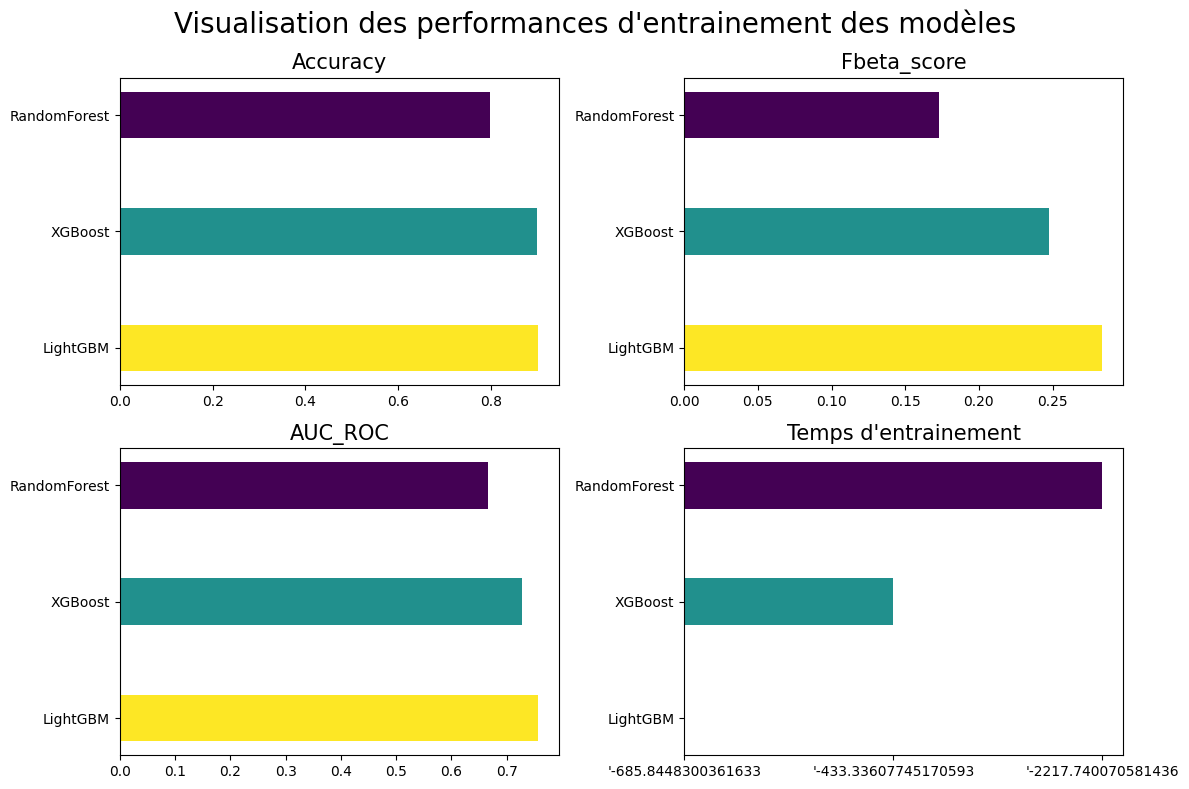

In [48]:
# visualisation des performances
import matplotlib.pyplot as plt
import seaborn as sns
cmap = plt.cm.viridis_r
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
fig,axs = plt.subplots (2,2,figsize=(12,8))
axs[0,0].barh(balanced_exp['model'],balanced_exp['accuracy'], height = 0.4, color = colors )
axs[0,0].set_title('Accuracy', fontsize = 15)
axs[0,1].barh(balanced_exp['model'],balanced_exp['fbeta'], height = 0.4, color = colors)
axs[0,1].set_title('Fbeta_score', fontsize = 15)
axs[1,0].barh(balanced_exp['model'],balanced_exp['roc_auc'], height = 0.4, color = colors)
axs[1,0].set_title('AUC_ROC', fontsize = 15)
axs[1,1].barh(balanced_exp['model'],balanced_exp['train_time'], height = 0.4, color = colors)
axs[1,1].set_title('Temps d\'entrainement', fontsize = 15)

plt.suptitle("Visualisation des performances d'entrainement des modèles", fontsize = 20)
plt.tight_layout()
plt.show()


#### 4-3-2 Récupération avec l'outil MLFlow Tracking

In [49]:
experiment_name = "Solvabilite_client_balanced"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///content/mlruns/331611894679559092', creation_time=1757483023734, experiment_id='331611894679559092', last_update_time=1757483023734, lifecycle_stage='active', name='Solvabilite_client_balanced', tags={}>

In [50]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.fbeta DESC"],  # trier par métrique fbeta_score
)

In [51]:
runs

[<Run: data=<RunData: metrics={'accuracy': 0.9018421865600053,
  'fbeta': 0.2837940952045548,
  'roc_auc': 0.7571062836476139,
  'train_time': -685.8448300361633}, params={'model': 'LightGBM',
  'model__learning_rate': '0.10488855372533333',
  'model__max_depth': '7',
  'model__n_estimators': '113',
  'model__num_leaves': '28'}, tags={'mlflow.runName': 'LightGBM',
  'mlflow.source.name': '/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py',
  'mlflow.source.type': 'LOCAL',
  'mlflow.user': 'root'}>, info=<RunInfo: artifact_uri='file:///content/mlruns/331611894679559092/2af2bd5480174a22b35cf53023a0b0b6/artifacts', end_time=1757486437537, experiment_id='331611894679559092', lifecycle_stage='active', run_id='2af2bd5480174a22b35cf53023a0b0b6', run_name='LightGBM', start_time=1757486429007, status='FINISHED', user_id='root'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[<LoggedModelOutput: model_id='m-2c700ff82fca45c4b08fbb75d8ec9

In [52]:
# on récupère le top_run
best_run = runs[0]
print("Run ID:", best_run.info.run_id)
print("Paramètres:", best_run.data.params)
print("Metrics:", best_run.data.metrics)

Run ID: 2af2bd5480174a22b35cf53023a0b0b6
Paramètres: {'model__num_leaves': '28', 'model__max_depth': '7', 'model__learning_rate': '0.10488855372533333', 'model': 'LightGBM', 'model__n_estimators': '113'}
Metrics: {'train_time': -685.8448300361633, 'fbeta': 0.2837940952045548, 'accuracy': 0.9018421865600053, 'roc_auc': 0.7571062836476139}


In [53]:
# on récupère la meilleure combinaison d'hyperparamètres
params = best_run.data.params

In [54]:
params

{'model__num_leaves': '28',
 'model__max_depth': '7',
 'model__learning_rate': '0.10488855372533333',
 'model': 'LightGBM',
 'model__n_estimators': '113'}

On instancie le meilleur modèle avec ces hyperparamètres

In [55]:
best_model = LGBMClassifier (
    learning_rate = 0.10488855372533333,
    n_estimators = 113,
    max_depth=7,
    num_leaves=28,
    class_weight='balanced'
    )

In [56]:
best_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', smote),
    ('under', under),
    ('model', best_model)
    ])

### 4-5 Entrainement complet et évaluation des performances

In [57]:
# training
best_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 79146, number of negative: 121763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.224935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 200909, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CREDITCARD_CREDIT_UTILIZATION_MEAN',
                                                   'CREDITCARD_CNT_DRAWINGS_ATM_CURRENT_MEAN',
                                                   'CREDITCARD_CNT_DRAWINGS_CURRENT_MAX',
                                                   'CREDITCARD_CREDIT_UTILIZATION_MAX',
                                                   'DAYS_CRE...
                                                   'HOUR_APPR_PROCESS_START_mean', ...]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])])),
                ('over', SMOTE(random_state=42, sampling_strategy=0.35)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.65)),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                learning_rate=0.10488855372533333, max_depth=7,
                                n_estimators=113, num_leaves=28))])

In [58]:
# predictions
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [59]:
# évaluation des performances
# 1- fbeta_score
print("F2-score :", fbeta_score(y_test, y_pred, beta=2))

F2-score : 0.22144675621104382


In [60]:
# AUC_ROC
print("AUC-ROC :", roc_auc_score(y_test, y_proba))

AUC-ROC : 0.7673120731200082


Text(50.722222222222214, 0.5, 'Réel')

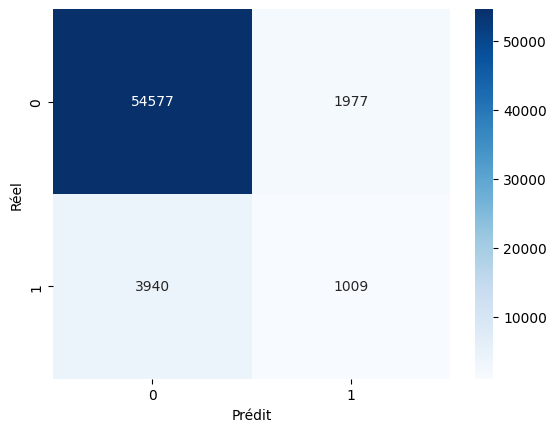

In [62]:
# matrice de correlation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")

On a 1977 FP et 3940 FN

In [63]:
# accuracy train
print("Accuracy train :", best_pipeline.score(X_train, y_train))
# accuracy test
print("Accuracy test :", best_pipeline.score(X_test, y_test))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy train : 0.9086899613020715


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy test : 0.9037933108954035


### 4-6 Analyse de la feature_importance locale et globale

### 4-6-1 analyse de la feature_importance locale (LIME)

LIME tente d'expliquer une prédiction au hasard réalisée par le modèle :

- on génère des perturbations de la prédiction

- on regarde comment le modèle s'adapte

- on utilise un modèle simple qui attribue un poids à chacune des features

On identifie ainsi les features qui ont contribué à cette prédiction locale précise

In [65]:
# évaluation de la feature_importance globale
import lime
from lime.lime_tabular import LimeTabularExplainer

In [77]:
# 1. Créer l’explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Solvable', 'Mauvais payeur'],
    mode='classification'
)

In [75]:
# 2. Sélectionner une observation à expliquer (client n°10)
i = 1000
instance = X_test.iloc[i].to_numpy()

In [78]:
# 3. Générer l’explication locale
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=best_model.predict_proba
)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.

In [ ]:
# 4. Visualiser
exp.show_in_notebook(show_table=True)
exp.as_list()

#### 4-6-2 analyse de la feature_importance globale (SHAP)

In [69]:
import shap

In [70]:
# 1- créer l'explainer
explainer = shap.TreeExplainer(best_model)

In [71]:
# 2- calcul des valeurs shap
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


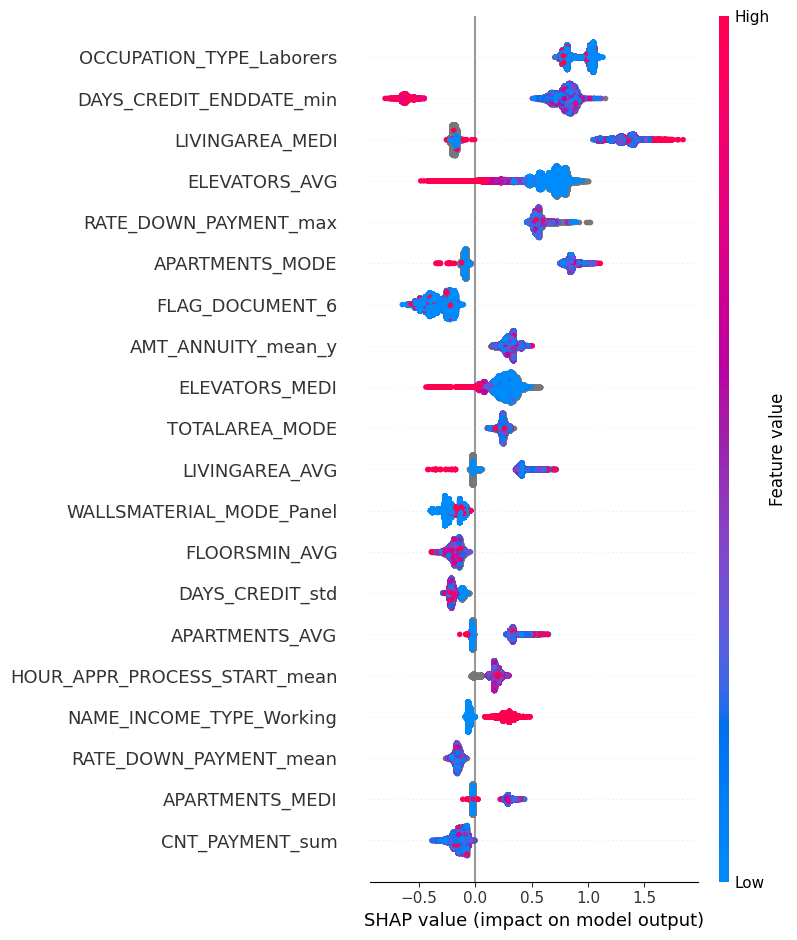

In [72]:
# 3- Importance_globale
shap.summary_plot(shap_values, X_test)